In [1]:
import pandas as pd
import numpy as np
import multiprocessing
from bs4 import BeautifulSoup as bs
from selectolax.parser import HTMLParser
import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string
from tensorflow.keras.preprocessing.text import Tokenizer

from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

2023-03-15 16:34:57.058905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Data loading and preparation
data = pd.read_json('../datasets/dataset.json')
mapping = {False: 0, True: 1}
data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['violation'], axis=1, inplace=True)
data.shape

(86439, 2)

In [4]:
data.head()

,text,labels
0,My Favorite Slut,0
1,girlfriends sit on each other's faces with the...,0
2,bound beauty kisses her girlfriend,0
3,MORGAN - Anytime - Nail Painting On The Slave'...,0
4,TRANSGENDER COACHING (wmv) PART 1,0


# Preprocessing function

In [5]:
def preprocess(text, stop_words, punctuation_marks): #, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = token #morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

punctuation_marks = ['!', ',', ';', '(', ')', ':', '-', '--', '', '?', '@', '....',
                     '.', '..', '...', '<', '>', '=', '\'\'', '//', '»', '|', '’',
                     '\"\"', '</', '&', '/', '#', '\'', '*', '``', '%', '[', ']', '{', '}']

stop_words = stopwords.words('english') + ['14000kbps', "n't", "'s", "'m", 'mp4']
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [6]:
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s

In [7]:
data[:1000].apply(lambda row: str(row.text), axis=1)

0                                       My Favorite Slut
1      girlfriends sit on each other's faces with the...
2                     bound beauty kisses her girlfriend
3      MORGAN - Anytime - Nail Painting On The Slave'...
4                      TRANSGENDER COACHING (wmv) PART 1
                             ...                        
995    Captain Next Fucks Hot Wife Laney On Her Husba...
996    Captain Next Fucks Hot Wife Laney On Her Husba...
997    Captain Next Fucks Hot Wife Laney On Her Husba...
998    XY19 - Sexy Chinese Maid Gets Femdom With Vibr...
999     The Strongest Reverse Headscissors Contest HDMP4
Length: 1000, dtype: object

In [8]:
data.head()

,text,labels
0,My Favorite Slut,0
1,girlfriends sit on each other's faces with the...,0
2,bound beauty kisses her girlfriend,0
3,MORGAN - Anytime - Nail Painting On The Slave'...,0
4,TRANSGENDER COACHING (wmv) PART 1,0


In [9]:
data[:100].apply(lambda row: bs(row['text']).get_text().replace('\n',' '),axis=1)

0                                      My Favorite Slut
1     girlfriends sit on each other's faces with the...
2                    bound beauty kisses her girlfriend
3     MORGAN - Anytime - Nail Painting On The Slave'...
4                     TRANSGENDER COACHING (wmv) PART 1
                            ...                        
95    Real Mesmerized Housewife of Brooklyn follows ...
96              Kaylia strict hogtie naked on the floor
97                 Real Mesmerized Submissive Housewife
98                       EHESKLAVE MUSS FÜSSE LUTSCHEN!
99    Uncut, Buck Nekkid fucks and creampies Polly B...
Length: 100, dtype: object

In [10]:
data[:100].apply(lambda row: preprocess(row.text, punctuation_marks, stop_words), axis=1) #, morph), axis=1)

0                                         favorite slut
1                           girlfriends sit faces asses
2                        bound beauty kisses girlfriend
3               morgan anytime nail painting slave face
4                       transgender coaching wmv part 1
                            ...                        
95    real mesmerized housewife brooklyn follows orders
96                     kaylia strict hogtie naked floor
97                 real mesmerized submissive housewife
98                        ehesklave muss füsse lutschen
99    uncut buck nekkid fucks creampies polly bundy ...
Length: 100, dtype: object

In [11]:
data['text_preprocessed'] = data.apply(lambda row: bs(row.text).get_text().replace('\n',' '),axis=1)
# data['text_preprocessed'] = data.apply(lambda row: HTMLParser(row.text).body.text(separator=' ').replace('\n',' '),axis=1)

In [12]:
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text_preprocessed, punctuation_marks, stop_words), axis=1)

In [13]:
data = data[['text_preprocessed', 'labels', 'text']] # columns reorder

In [14]:
data.head()

,text_preprocessed,labels,text
0,favorite slut,0,My Favorite Slut
1,girlfriends sit faces asses,0,girlfriends sit on each other's faces with the...
2,bound beauty kisses girlfriend,0,bound beauty kisses her girlfriend
3,morgan anytime nail painting slave face,0,MORGAN - Anytime - Nail Painting On The Slave'...
4,transgender coaching wmv part 1,0,TRANSGENDER COACHING (wmv) PART 1


# Tensorflow

In [15]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count  

In [16]:
counter = counter_word(data.text_preprocessed)  

In [17]:
data.text_preprocessed

0                                            favorite slut
1                              girlfriends sit faces asses
2                           bound beauty kisses girlfriend
3                  morgan anytime nail painting slave face
4                          transgender coaching wmv part 1
                               ...                        
86434    enought visit us social media sites updates ch...
86435                                                     
86436                                                     
86437                                                     
86438                                                     
Name: text_preprocessed, Length: 86439, dtype: object

In [26]:
num_unique_words = len(counter)

In [27]:
counter

Counter({'favorite': 384,
         'slut': 2088,
         'girlfriends': 187,
         'sit': 784,
         'faces': 284,
         'asses': 344,
         'bound': 1992,
         'beauty': 570,
         'kisses': 342,
         'girlfriend': 515,
         'morgan': 251,
         'anytime': 76,
         'nail': 454,
         'painting': 114,
         'slave': 6945,
         'face': 7114,
         'transgender': 124,
         'coaching': 8,
         'wmv': 1872,
         'part': 2706,
         '1': 1428,
         '2212terra-kept': 1,
         'tied': 2165,
         'gagged': 1716,
         'garage': 24,
         'cadence': 94,
         'gets': 1828,
         'catfished': 3,
         '2': 1803,
         '3': 959,
         'mobile': 309,
         'lick': 1541,
         'sexy': 7149,
         'mules': 154,
         'clean': 753,
         'shoe': 2123,
         'worship': 8543,
         'domination': 10288,
         'gorgeous': 672,
         'yet': 248,
         'hangry': 2,
         'amazonia

In [28]:
counter.most_common(5)

[('fetish', 25589),
 ('feet', 20644),
 ('foot', 19158),
 ('ass', 13228),
 ('big', 10813)]

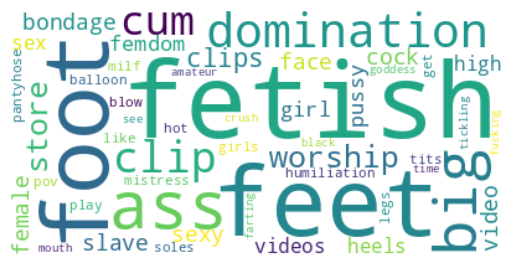

In [29]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [30]:
train_size = int(data.shape[0] * .8)

train = data[:train_size]
val = data[train_size:]

# Split train and test

X_train = train.text_preprocessed.to_numpy()
y_train = train.labels.to_numpy()

X_val = val.text_preprocessed.to_numpy()
y_val = val.labels.to_numpy()

In [31]:
X_train.shape, X_val.shape

((69151,), (17288,))

# Tokenize

In [32]:
# vectorize a text corpus by turning each text into sentence of integers

tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(X_train)

In [34]:
# each word have a unique index
word_index = tokenizer.word_index
word_index

{'fetish': 1,
 'feet': 2,
 'foot': 3,
 'ass': 4,
 'big': 5,
 'domination': 6,
 'cum': 7,
 'worship': 8,
 'clip': 9,
 'bondage': 10,
 'clips': 11,
 'cock': 12,
 'face': 13,
 'girl': 14,
 'sexy': 15,
 'slave': 16,
 'female': 17,
 'store': 18,
 'pussy': 19,
 'video': 20,
 'femdom': 21,
 'heels': 22,
 'high': 23,
 'videos': 24,
 'sex': 25,
 'humiliation': 26,
 'soles': 27,
 'pantyhose': 28,
 'girls': 29,
 'get': 30,
 'legs': 31,
 'balloon': 32,
 'blow': 33,
 'mistress': 34,
 'tits': 35,
 'pov': 36,
 'hot': 37,
 'like': 38,
 'play': 39,
 'milf': 40,
 'fucking': 41,
 'tickling': 42,
 'mouth': 43,
 'time': 44,
 'crush': 45,
 'goddess': 46,
 'black': 47,
 'stockings': 48,
 'farting': 49,
 'amateur': 50,
 'see': 51,
 'fuck': 52,
 'toes': 53,
 'long': 54,
 'smoking': 55,
 'one': 56,
 'socks': 57,
 'full': 58,
 'masturbation': 59,
 'tease': 60,
 'hd': 61,
 'hard': 62,
 'want': 63,
 'spanking': 64,
 'dirty': 65,
 'crushing': 66,
 'anal': 67,
 'wrestling': 68,
 'little': 69,
 'training': 70,
 'shoe

In [35]:
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [39]:
X_train[10:15]

[[1225, 3145, 191, 15, 1758, 433, 114, 8, 6],
 [493, 1226, 25716, 7143],
 [2375, 593, 10062, 6756, 126, 850, 3611, 1949],
 [25717, 3808],
 [1225, 3145, 13, 1486, 3, 8]]

In [40]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
